# Resampling Methods for Model Selection and Evaluation

### What is resampling?
A resampling method is a tool consisting in repeatedly drawing samples from a dataset and calculating statistics and metrics on each of those samples in order to obtain further information about something, in the machine learning setting, this something is the performance of a model. But in case of merely statistical analysis this could be additional insight about the behavior of some parameter

#### We use resampling for two goals:

To select among model configurations
To evaluate the performance of our models in new data
There are two kinds of problems that can emerge from selecting a sub-optimal resampling approach

We can get a biased estimate of model performance (i.e., we can systematically under or over-estimate its performance)
We can get an imprecise estimate of model performance (i.e., high variance in our model performance metric)
Essentially, this is the bias and variance problem again, but now not with respect to the model’s actual performance but instead with our estimate of how the model will perform

This is a very important distinction to keep in mind or you will be confused as we discuss bias and variance into the future. We have:

bias and variance of model performance (i.e., the predictions the model makes)
bias and variance of our estimate of how well the model will perform in new data
different factors affect each

In [230]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut, RepeatedKFold
from sklearn.linear_model import LogisticRegression

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier


#Import graphical plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [231]:
# Dataset is hosted on my github repository
url = "https://raw.githubusercontent.com/midhunmohank/DS/master/Datasets/heart_cleveland_upload.csv"
df = pd.read_csv(url)

### Dataset Feature Infromation
1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
        -- Value 0: typical angina
        -- Value 1: atypical angina
        -- Value 2: non-anginal pain
        -- Value 3: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
        -- Value 0: upsloping
        -- Value 1: flat
        -- Value 2: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect 
and the label
14. condition: 0 = no disease, 1 = disease

In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [233]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


In [234]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [235]:
df.isna().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

In [236]:
df.shape

(297, 14)

In [237]:
target = df['condition']
features = df.drop('condition', 1)

/var/folders/6n/jn9tfjdx2f98kc2l68s832bm0000gn/T/ipykernel_15554/948175804.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features = df.drop('condition', 1)


In [238]:
X_train, X_test, y_train, y_test = train_test_split(features, target,test_size=0.5, random_state=42)

In this artcile, we will focus on assessing the performance of a single model configuration

1. Logistic regression algorithm
2. No hyper-parameters
3. All available predictors and we will call the held-out set a test set and use it to evaluate the expected future performance of this single configuration

In [239]:
model = LogisticRegression().fit(features, target)

/Users/midhunmohan/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [240]:
predictions = model.predict(X_test)

In [241]:
# Use score method to get accuracy of model
score = model.score(features, target)
print(score)

0.8518518518518519


### Leave One Out Cross Validation

Let’s turn to a new resampling technique and start with some questions to motivate it

How could you use this single validation set approach to get the least biased estimate of model performance with your n = 303 dataset that would still allow you to estimate its performance in a held out test set?

What will be the biggest problem with this approach?

How might you reduce this problem?

Comparisons across LOOCV and Single Validation Set Approaches

The performance estimate from LOOCV has less bias than the single validation set method (because the models that are evaluated were fit with close to the full n of the final model)

LOOCV uses all observations as “test” at some point. Less variance than single 20% or 50% validation set?

But…

LOOCV can be computationally expensive (need to fit and evaluate the same model configuration n times). This is a real problem when you are also working with a high number of model configurations (i.e., number fits = n * number of model configurations).
LOOCV eventually uses all the data for test across the ‘n’ test sets. Averaging also helps reduce variance in the performance metric.

However, averaging reduces variance to a greater degree when the performance measures being averaged are less related/more independent.

The n fitted models are VERY similar in LOOCV b/c they are each fit on almost the same data (each with n-1 observations)

K-fold cross validation (next method) improves the variance of the average performance metric by averaging across more independent (less overlapping) training sets

For this reason, it is superior and (always?) preferred over LOOCV

We are not demonstrating LOOCV b/c we strongly prefer other methods (K-fold)

Still important to understand it conceptually and its strengths/weaknesses
If you wanted to use this resampling approach, simply substitute loo_cv() for vfold_cv() in the next example

### K-fold Cross Validation

1. Divide the observations into K equal size independent “folds” (each observation appears in only one fold)
2. Hold out 1 of these folds (1/Kth of the dataset) to use as a test set
3. Fit a model in the remaining K-1 folds
4. Repeat until each of the folds has been held out once
5. Performance estimate is the average performance across the K held out folds
6. Common values of K are 5 and 10

Note that K is sometimes referred to as V in some fields/literatures (Don’t blame me!)

In [257]:
kfold = KFold(n_splits=10, random_state=0, shuffle=True)
model = LogisticRegression(solver='liblinear')

In [258]:
results = cross_val_score(model, X_train, y_train, cv=kfold)

In [259]:
# Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 82.381% (9.216%)


#### You can repeat the K-fold procedure multiple times with new splits for a different mix of K folds each time

Two benefits:

1. More stable performance estimate (because averaged over more folds: repeats * K)
2. Many more estimates of performance to characterize (SE; plot) of your performance estimate
3. But it is computationally expensive (depending on number of repeats)

In [260]:
Repeatedkfold = RepeatedKFold(n_splits=10, n_repeats = 10,random_state=0)
model = LogisticRegression(solver='liblinear')

In [261]:
repeatedresults = cross_val_score(model, X_train, y_train, cv=Repeatedkfold)
repeatedresults

array([0.93333333, 0.66666667, 0.8       , 0.93333333, 0.93333333,
       0.86666667, 0.73333333, 0.8       , 0.85714286, 0.71428571,
       0.93333333, 1.        , 0.8       , 1.        , 0.86666667,
       0.73333333, 0.86666667, 0.8       , 0.71428571, 0.71428571,
       0.93333333, 0.8       , 0.8       , 0.8       , 0.93333333,
       0.8       , 0.8       , 0.66666667, 0.92857143, 0.78571429,
       0.86666667, 1.        , 0.8       , 0.73333333, 0.86666667,
       0.86666667, 0.8       , 0.86666667, 0.85714286, 0.78571429,
       0.93333333, 1.        , 0.6       , 0.86666667, 0.86666667,
       0.86666667, 0.66666667, 0.86666667, 1.        , 0.78571429,
       0.86666667, 0.86666667, 0.66666667, 0.86666667, 0.93333333,
       0.93333333, 0.73333333, 0.93333333, 0.92857143, 0.85714286,
       0.86666667, 0.73333333, 0.93333333, 0.8       , 0.8       ,
       0.86666667, 0.86666667, 0.86666667, 0.78571429, 1.        ,
       0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666

In [262]:
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 82.381% (9.216%)


#### Comparisons between repeated K-fold and K-fold

Repeated K-fold:

1. Has same bias as K-fold (still fitting models with K-1 folds)
2. Has all the benefits of single K-fold
3. Has even more stable estimate of performance (mean over more folds/repeats)
4. Provides more info about distribution for the performance estimate
5. But is more computationally expensive
6. Repeated K-fold is preferred over K-fold to the degree possible based on computational limitations (parallel, N, p, statistical algorithm, # of model configurations)

#### Thumb Rules Associated with K Fold
Now, we will discuss a few thumb rules while playing with K – fold

1. K should be always >= 2 and = to number of records, (LOOCV)
2. If 2 then just 2 iterations
3. If K=No of records in the dataset, then 1 for testing and n- for training
4. The optimized value for the K is 10 and used with the data of good size. (Commonly used)
5. If the K value is too large, then this will lead to less variance across the training set and limit the model currency difference across the iterations.
6. The number of folds is indirectly proportional to the size of the data set, which means, if the dataset size is too small, the number of folds can increase.
7. Larger values of K eventually increase the running time of the cross-validation process.

### Bootstrap Resampling

A bootstrap sample is a random sample taken with replacement (i.e., same observations can be sampled multiple times within one bootstrap sample)

If you bootstrap a new sample of size n from a dataset with sample size n, approximately 63.2% of the original observations end up in the bootstrap sample

The remaining 36.8% of the observations are often called the “out of bag” (OOB) samples

Bootstrap Resampling

Creates B bootstrap samples of size n = n from the original dataset
For any specific bootstrap (b)
Model(s) are fit to the bootstrap sample
Model performance is evaluated in the associated out of bag (held-out) samples
This is repeated B times such that you have B assessments of model performance


Bootstrap aggregating, also called Bagging, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach. Bagging leads to "improvements for unstable procedures", which include, for example, artificial neural networks, classification and regression trees, and subset selection in linear regression. On the other hand, it can mildly degrade the performance of stable methods such as K-nearest neighbors.

In [263]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

In [264]:
#Lets configure Bootstrap

n_iterations = 10  #No. of bootstrap samples to be repeated (created)
n_size = int(len(df) * 0.50) #Size of sample, picking only 50% of the given data in every bootstrap sample

In [265]:
values = df.values

In [266]:
#Lets run Bootstrap
stats = list()
for i in range(n_iterations):

    #prepare train & test sets
    train = resample(values, n_samples = n_size) #Sampling with replacement..whichever is not used in training data will be used in test data
    test = np.array([x for x in values if x.tolist() not in train.tolist()]) #picking rest of the data not considered in training sample
    
    #fit model
    model.fit(train[:,:-1], train[:,-1]) #model.fit(X_train,y_train) i.e model.fit(train set, train label as it is a classifier)
    
    #evaluate model
    predictions = model.predict(test[:,:-1]) #model.predict(X_test)
    score = accuracy_score(test[:,-1], predictions) #accuracy_score(y_test, y_pred)
    #caution, overall accuracy score can mislead when classes are imbalanced
    
    print(score)
    stats.append(score)

0.8514285714285714
0.8192090395480226
0.8171428571428572
0.8186813186813187
0.8076923076923077
0.8547486033519553
0.8095238095238095
0.8295454545454546
0.7988826815642458
0.8


<Figure size 720x360 with 0 Axes>

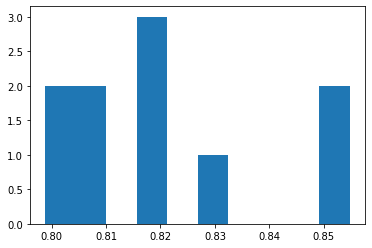

<Figure size 720x360 with 0 Axes>

In [267]:
plt.hist(stats)
plt.figure(figsize = (10,5))

In [268]:
#Lets find Confidence intervals

a = 0.95 # for 95% confidence
p = ((1.0 - a)/2.0) * 100 #tail regions on right and left .25 on each side indicated by P value (border)
                          # 1.0 is total area of this curve, 2.0 is actually .025 thats the space we would want to be 
                            #left on either side
lower = max(0.0, np.percentile(stats,p))

p = (a + ((1.0 - a)/ 2.0)) * 100 #p is limits
upper = min(1.0, np.percentile(stats,p))
print('%.1f confidence interval %.1f%% and %.1f%%' %(a*100, lower*100, upper*100))

95.0 confidence interval 79.9% and 85.4%


**This model is likely to give an accuracy score of 86.0% +- 10.621(std dev). Putting this in normal distribution, you will get the score as per Central Limit theorem**


#### Relevant comparisons, strengths/weaknesses for bootstrap for resampling

Our performance estimate will have higher bias than K-fold using typical K values (bias equivalent to about K = 2)

Although training sets have full n, they only include about 63% unique observations. These models under perform training sets with 80 - 90% unique observations
With smaller training set sizes, this bias is considered too high by some (Kuhn)
Our performance estimate will have less variance than K-fold

Compare SE of accuracy for 100 resamples using k-fold with repeats: 0.0063189 vs. bootstrap: 0.0034271
With 1000 bootstraps (and test sets with ~ 37% of n) can get a very precise estimate of test error
Can also represent the variance of our test error (like repeated K-fold)

Used primarily for selecting among model configurations when you don’t care about bias and just want a precise selection metric

Useful in explanation scenarios where you just need the “best” model
“Inner loop” of nested cross validation (more on this later)

### Using Resampling to Select Best Model Configurations
Resampling is also used to select best models. Best means the model configuration that performs the best in new data and therefore is closest to the true DGP for the data

For example, we might want to select among model configurations in an explanatory scenario to have a principled approach to determine the model configuration that best matches the true DGP (and would be best to test your hypotheses). e.g.,
Selecting covariates to include
Deciding on X transformations
outlier identification approach
statistical algorithm
We can simply evaluate each configuration using one of the previously described resampling methods
We would call the held-out data (the single set, the folds, the OOB samples) a validation set
We select the model configuration with the best mean across our resampled validation sets on the relevant performance metric.

### Resampling methods can be used to select the best model configuration and/or evaluate model performance

So far we have done EITHER selection OR evaluation but not both together

The concepts to both select the best configuration and evaluation it are similar but it requires different (slightly more complicated) resampling than what we have done so far

If you use your held-out resamples to select the best model among a number of model configurations then the same held out resamples cannot also be used to evaluate the performance of that same best model

If it is, the performance metric will have ‘optimization bias.’ To the degree that there is any noise (i.e., variance) in the measurement of performance, selecting the best model configuration will capitalize on this noise.

You need to use one set of held out resamples (validation sets) to select the best model. Then you need a DIFFERENT set of held out resamples (test sets) to evaluate that best model.

There are two strategies for this:

Strategy 1: First, hold out a test set for final/best model evaluation. Then use one of the above resampling methods (single validation set approach, k-fold or bootstrap) to select the best model configuration. Bootstrap is likely best option b/c it is typically more precise (though biased)

Strategy 2: Nested resampling. More on this in a moment

### Conclusion


This article compared Leave One out CV, K-fold, repeated K fold and Bootstrap resampling on a Logistic Regression configuration model and compared the accuracy of the model after each type of CV was applied while also comparing the tradeoffs of each method with the other in a given condition.

References:
1. Unit 5 Resampling Methods for Model Selection and Evaluation (https://dionysus.psych.wisc.edu/iaml/unit-05.html)
2. 3.1. Cross-validation: evaluating estimator performance (https://scikit-learn.org/stable/modules/cross_validation.html)
3. Linear Regression With Bootstrapping (https://towardsdatascience.com/linear-regression-with-bootstrapping-4924c05d2a9)
4. How to Use Approximate Leave-one-out Cross-validation to Build Better Models (https://hackernoon.com/how-to-use-approximate-leave-one-out-cross-validation-to-build-better-models-vg1u35g2)
5. RepeatedKFold (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html)

Licences:
1. Pandas 1.4 https://pandas.pydata.org/docs/getting_started/overview.html
2. Logistic Regression sklearn -- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### MIT License
Copyright (c) 2022 Midhun Mohan Kudayattutharayil

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.